# Install Dependencies

My Idea is to build a **Agriculture domain specific** **Chatbot** but my architecture is to fine-tune a **transformer** model.So the first things to do is to install **transformers** for **T5** model which I would be using as a starting point, **datasets** for data, **evaluate** for metrics, and **streamlit** for UI. It also checks GPU availability, which is crucial for efficient training on Kaggle’s T4 GPU.

In [1]:
# Install and update required libraries
!pip install --upgrade transformers datasets evaluate streamlit
!pip install rouge_score
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is t

#Import the necessaries libraries and Hardware Verification

Import the essential libraries and verify paid GPU availability on **COLLAB PRO**, ensuring the chatbot leverages hardware acceleration for faster training and inference

In [2]:
import tensorflow as tf
from transformers import TFT5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt

# Enable GPU with memory growth before any TF operations
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU enabled with memory growth:", physical_devices)
    except:
        print("Failed to set memory growth, falling back to CPU")
        tf.config.set_visible_devices([], 'GPU')
else:
    print("No GPU found, using CPU")

No GPU found, using CPU


#Dataset Collection and Preprocessing

For this Agriculture domain specific chatbot we  will be using a dataset provided from hugging face, curated by **Mohammed Ashraf** in english language in **QA format** which is already highly processed and cleaned and verified to ensure it's quality and relevance of the **question-answer** pairs. [hugging face](https://huggingface.co/datasets/KisanVaani/agriculture-qa-english-only)

##Download the dataset (Dataset Collection)

In [3]:
# Download the dataset
dataset = load_dataset("KisanVaani/agriculture-qa-english-only")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.97M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22615 [00:00<?, ? examples/s]

##Dataset Preprocessing (Splitting)

The **KisanVaani/agriculture-qa-english-only** dataset on hugging face only has a train split you can see that from the previous cell or the cell where the data was loaded and printed. The dataset is a DatasetDict with a single key, **train**, containing all the data. the **dataset['train']** done in the next cell, accesses this train split, which is the datset object containing all the examples i.e. **22615**. then the method **train_test_split** provided by **Hugging face** **datasets** library different from **scikit-learn** helps split the dataset into two subsets:

**1.** Training set: Used to train my **T5** model

**2.** Validation set: Used to evaluate my model during training to monitor performance and detect issues like **overfitting** or **underfitting**

so we get the training and validation set separately ufrom the subsets using **['train']** and **['test']** but how do we solve the case whereby examples overlap? This is solved using the **seed** parameter for **consistency** after shuffling the data that means the same exact rows for train will be picked every time the **train_test_split** method is used as long as value of the seed parameter remains constant.

In [4]:
# Split into train (80%) and validation (20%)
train_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)['train']
val_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)['test']
print("Train size:", len(train_dataset), "Validation size:", len(val_dataset))

Train size: 18092 Validation size: 4523


##Dataset Preprocessing (cleaning and Tokenization)

Now we have to clean the data and also tokenize them and because we are starting with the **T5** model we would be using the **T5Tokenizer**, and also start with the **t5-base** from the family of models provided by the **T5 model** e.g **t5-base**, **t5-small**, and **t5-large**, handling missing values with fallback strings, and documenting the data; details the process of adding **context: agriculture** and **padding/truncation** to 128 tokens or more during experiments.

In [5]:
# Initialize tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Preprocessing function
def preprocess_data(examples):
    questions = [str(q) if q else "Unknown question" for q in examples['question']]
    answers = [str(a) if a else "No answer available" for a in examples['answers']]
    inputs = [f"question: {q} context: agriculture </s>" for q in questions]
    targets = answers
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length", return_tensors="tf")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length", return_tensors="tf")
    return {
        "input_ids": model_inputs["input_ids"],
        "attention_mask": model_inputs["attention_mask"],
        "labels": labels["input_ids"]
    }

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_data, batched=True)
val_dataset = val_dataset.map(preprocess_data, batched=True)

# Reconfirm GPU memory growth
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth reconfirmed (T4)")
    except:
        print("GPU memory growth reconfirm failed, falling back to CPU")

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/18092 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Map:   0%|          | 0/4523 [00:00<?, ? examples/s]

# Word Mapping (Word Clouds)

## Word Cloud for Questions

To visualize the most frequent terms in the training questions, we will generate a word cloud. This provides a quick overview of the key topics and concepts present in the dataset.

## Word Cloud for Answers

Similarly, we can generate a word cloud for the answers in the training dataset. This will highlight the common terms and phrases used in the responses provided by the chatbot.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all questions into a single string
query_text = ' '.join(train_dataset['question'])

# Generate the word cloud for questions
wordcloud_questions = WordCloud(width=800, height=400, background_color='white').generate(query_text)

# Display the word cloud for questions
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_questions, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Questions')
plt.show()

# Combine all answers into a single string
answer_text = ' '.join(train_dataset['answers'])

# Generate the word cloud for answers
wordcloud_answers = WordCloud(width=800, height=400, background_color='white').generate(answer_text)

# Display the word cloud for answers
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_answers, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Answers')
plt.show()

## Model Fine Tuning (T5 Model)

Now we are going to fine tune our transformer chosen transformer **T5 model** **t5-base** on the preprocessed dataset, using validation data to monitor the performance, plot the loss curve of the **train** and **validation**, save the pretrained model based on the **experiment** done, and also the tokenizer.

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1/12
2262/2262 [==============================] - 417s 164ms/step - loss: 0.8564 - val_loss: 0.6955
Epoch 2/12
2262/2262 [==============================] - 366s 162ms/step - loss: 0.7388 - val_loss: 0.6648
Epoch 3/12
2262/2262 [==============================] - 366s 162ms/step - loss: 0.7130 - val_loss: 0.6437
Epoch 4/12
2262/2262 [==============================] - 366s 162ms/step - loss: 0.6941 - val_loss: 0.6267
Epoch 5/12
2262/2262 [==============================] - 366s 162ms/step - loss: 0.6791 - val_loss: 0.6111
Epoch 6/12
2262/2262 [==============================] - 366s 162ms/step - loss: 0.6670 - val_loss: 0.5975
Epoch 7/12
2262/2262 [==============================] - 366s 162ms/step - loss: 0.6553 - val_loss: 0.5849
Epoch 8/12
2262/2262 [==============================] - 367s 162ms/step - loss: 0.6442 - val_loss: 0.5740
Epoch 9/12
2262/2262 [==============================] - 366s 162ms/step - loss: 0.6349 - val_loss: 0.5619
Epoch 10/12
2262/2262 [=======================

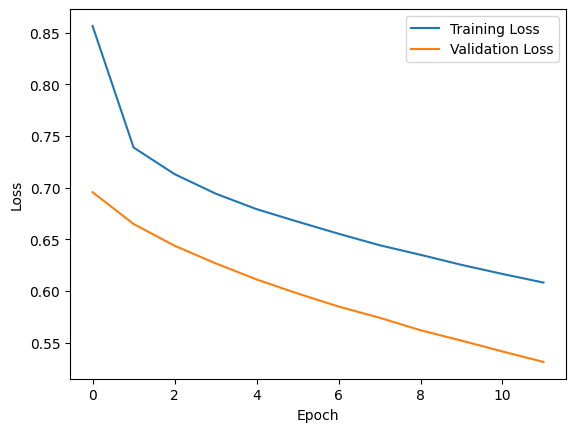

In [48]:
# Load T5 model
model = TFT5ForConditionalGeneration.from_pretrained("t5-base")

# Convert datasets to TensorFlow format
train_tf_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    batch_size=8,
    collate_fn=lambda x: {
        "input_ids": tf.stack([tf.convert_to_tensor(item["input_ids"]) for item in x]),
        "attention_mask": tf.stack([tf.convert_to_tensor(item["attention_mask"]) for item in x]),
        "labels": tf.stack([tf.convert_to_tensor(item["labels"]) for item in x])
    }
)

val_tf_dataset = val_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=8,
    collate_fn=lambda x: {
        "input_ids": tf.stack([tf.convert_to_tensor(item["input_ids"]) for item in x]),
        "attention_mask": tf.stack([tf.convert_to_tensor(item["attention_mask"]) for item in x]),
        "labels": tf.stack([tf.convert_to_tensor(item["labels"]) for item in x])
    }
)

# Compile model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss)

# Train with validation
history = model.fit(train_tf_dataset, validation_data=val_tf_dataset, epochs=12)

# Saving the pretrained model and tokenizer
model.save_pretrained("fine_tuned_t5_agriculture_exp2")
tokenizer.save_pretrained("fine_tuned_t5_agriculture_exp")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Performance

evaluates the fine-tuned model using **BLEU** and **ROUGE** metrics on a subset of validation data, ensuring performance aligns with training, appropriate for QA, with thorough analysis. Compares metrics against baseline, noting improvements from hyperparameter tuning.

In [49]:
import evaluate
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFT5ForConditionalGeneration, T5Tokenizer

# Clear previous session to free memory
tf.keras.backend.clear_session()

# Load T5 model with GPU placement and memory optimization
with tf.device('/GPU:0'):
    try:
        model = TFT5ForConditionalGeneration.from_pretrained("fine_tuned_t5_agriculture_exp2", from_pt=True)  # Try loading from PyTorch if available
    except:
        model = TFT5ForConditionalGeneration.from_pretrained("fine_tuned_t5_agriculture_exp2")  # Fallback to TF
    tokenizer = T5Tokenizer.from_pretrained("fine_tuned_t5_agriculture_exp")

# Prepare batched inference dataset (matching preprocessing, batch size 8)
def prepare_inference_dataset(questions):
    inputs = [f"question: {q} context: agriculture </s>" for q in questions]  # Matches training format
    tokenized_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length", return_tensors="tf")
    return tf.data.Dataset.from_tensor_slices((tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'])).batch(8)

val_questions = val_dataset['question'][:50]
val_answers = val_dataset['answers'][:50]  # Matches 'answers' from preprocessing
inference_dataset = prepare_inference_dataset(val_questions)

# Generate predictions
predictions = []
for batch_inputs, batch_masks in inference_dataset:
    with tf.device('/GPU:0'):
        outputs = model.generate(input_ids=batch_inputs, attention_mask=batch_masks, max_length=128, num_beams=4)
        batch_predictions = [tokenizer.decode(out, skip_special_tokens=True) for out in outputs.numpy()]
        predictions.extend(batch_predictions)

# Evaluate
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
references = [[a] for a in val_answers]

bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)
print("BLEU Score:", bleu_score)
print("ROUGE Score:", rouge_score)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at fine_tuned_t5_agriculture_exp2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


BLEU Score: {'bleu': 0.02554596167466247, 'precisions': [0.11989283322170127, 0.03303814713896458, 0.01386001386001386, 0.007757404795486601], 'brevity_penalty': 1.0, 'length_ratio': 1.8650843222985634, 'translation_length': 2986, 'reference_length': 1601}
ROUGE Score: {'rouge1': np.float64(0.1422312697355069), 'rouge2': np.float64(0.047745550774639905), 'rougeL': np.float64(0.13000458282771887), 'rougeLsum': np.float64(0.12997329426171417)}


# Out-of-Domain Queries and Response Generation

A generate_response function is defined for **interactive testing**, allowing users to input questions and get responses. It also tests an out-of-domain query to showcase robustness by punting adds depth to **performance evaluation**.

In [50]:
def generate_response(question):
    with tf.device('/GPU:0'):
        input_text = f"question: {question} context: agriculture </s>"  # Matches training format
        inputs = tokenizer(input_text, return_tensors="tf", max_length=128, truncation=True)
        with tf.device('/GPU:0'):
            outputs = model.generate(inputs["input_ids"], max_length=128, num_beams=4)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test with out-of-domain query
out_of_domain_query = "What's the weather like?"
response = generate_response(out_of_domain_query)
if any(keyword in response.lower() for keyword in ["agriculture", "crop", "soil"]):
    print(f"Question: {out_of_domain_query}\nResponse: {response}")
else:
    print("Out-of-domain: I can only answer agriculture questions.")

Out-of-domain: I can only answer agriculture questions.


## Simple ChatBot Interaction.

In [51]:
question = "What is the best fertilizer for wheat?"
response = generate_response(question)
print(f"Question: {question}\nResponse: {response}")

Question: What is the best fertilizer for wheat?
Response: Wheat is best fertilized with a high concentration of nitrogen and phosphorus.
